In [ ]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torchvision.models as models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

### Original Echo Profiles

In [ ]:
data_dir = 'drive/MyDrive/echo_data/original'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
dataset = ImageFolder(root=data_dir, transform=transform)

In [ ]:
k_folds = 5
batch_size = 32

kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f'Fold {fold}')

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [ ]:
print(dataset.class_to_idx)

{'aluminium': 0, 'bark': 1, 'plastic': 2, 'textile': 3}


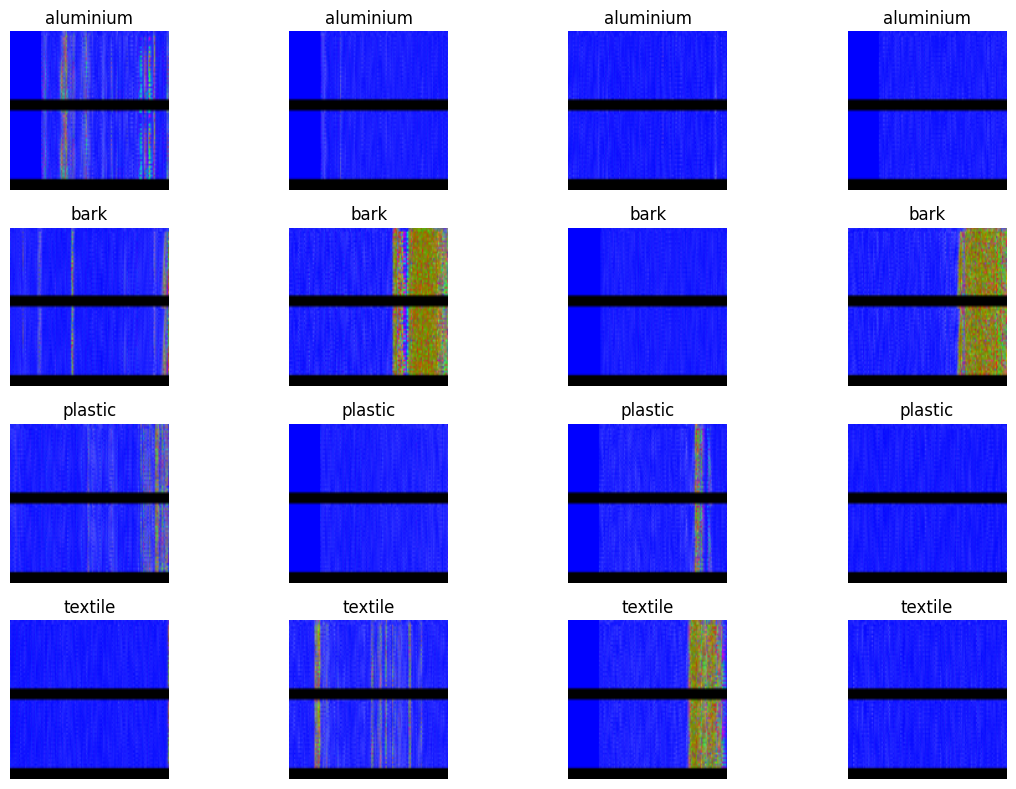

In [ ]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

samples_per_class = {class_name: 0 for class_name in dataset.classes}
max_samples = 4

fig = plt.figure(figsize=(12, 8))
shown = 0
for i in range(len(dataset)):
    img, label = dataset[i]
    class_name = dataset.classes[label]

    if samples_per_class[class_name] < max_samples:
        shown += 1
        ax = fig.add_subplot(len(dataset.classes), max_samples, shown)
        imshow(img, title=class_name)
        samples_per_class[class_name] += 1

    if all(v >= max_samples for v in samples_per_class.values()):
        break

plt.tight_layout()
plt.show()


In [ ]:
class ourCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(ourCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss()


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f'\n--- Fold {fold + 1} ---')

    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)

    model = ourCNN(num_classes=len(dataset.classes)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    for epoch in range(10):
        train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, loss_fn, device)

        print(f'Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)




--- Fold 1 ---
Epoch 1: Train Acc=0.23, Val Acc=0.34
Epoch 2: Train Acc=0.21, Val Acc=0.38
Epoch 3: Train Acc=0.26, Val Acc=0.22
Epoch 4: Train Acc=0.27, Val Acc=0.28
Epoch 5: Train Acc=0.29, Val Acc=0.24
Epoch 6: Train Acc=0.32, Val Acc=0.22
Epoch 7: Train Acc=0.27, Val Acc=0.29
Epoch 8: Train Acc=0.29, Val Acc=0.25
Epoch 9: Train Acc=0.32, Val Acc=0.16
Epoch 10: Train Acc=0.35, Val Acc=0.15

--- Fold 2 ---
Epoch 1: Train Acc=0.22, Val Acc=0.22
Epoch 2: Train Acc=0.26, Val Acc=0.19
Epoch 3: Train Acc=0.26, Val Acc=0.24
Epoch 4: Train Acc=0.26, Val Acc=0.24
Epoch 5: Train Acc=0.26, Val Acc=0.27
Epoch 6: Train Acc=0.29, Val Acc=0.28
Epoch 7: Train Acc=0.33, Val Acc=0.28
Epoch 8: Train Acc=0.29, Val Acc=0.25
Epoch 9: Train Acc=0.32, Val Acc=0.27
Epoch 10: Train Acc=0.34, Val Acc=0.30

--- Fold 3 ---
Epoch 1: Train Acc=0.25, Val Acc=0.23
Epoch 2: Train Acc=0.28, Val Acc=0.23
Epoch 3: Train Acc=0.24, Val Acc=0.24
Epoch 4: Train Acc=0.31, Val Acc=0.23
Epoch 5: Train Acc=0.32, Val Acc=0.21


In [ ]:
average_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_accuracy:.2f}')

Average Validation Accuracy: 0.24


In [ ]:
average_train_accuracy = sum(train_accuracies) / len(train_accuracies)
print(f'Average Training Accuracy: {average_train_accuracy:.2f}')

Average Training Accuracy: 0.29


In [ ]:
epoch_losses = [[] for _ in range(10)]
epoch_val_losses = [[] for _ in range(10)]
epoch_accuracies = [[] for _ in range(10)]
epoch_val_accuracies = [[] for _ in range(10)]

for i in range(len(train_losses)):
    epoch_losses[i % 10].append(train_losses[i])
    epoch_val_losses[i % 10].append(val_losses[i])
    epoch_accuracies[i % 10].append(train_accuracies[i])
    epoch_val_accuracies[i % 10].append(val_accuracies[i])

avg_epoch_losses = [sum(losses) / len(losses) if losses else 0 for losses in epoch_losses]
avg_val_losses = [sum(losses) / len(losses) if losses else 0 for losses in epoch_val_losses]
avg_accuracies = [sum(losses) / len(losses) if losses else 0 for losses in epoch_accuracies]
avg_val_accuracies = [sum(losses) / len(losses) if losses else 0 for losses in epoch_val_accuracies]
print(avg_epoch_losses)
print(avg_val_losses)
print(avg_accuracies)
print(avg_val_accuracies)

[1.4482497429847716, 1.3871018242835997, 1.3863357162475585, 1.3837387084960937, 1.3807781100273133, 1.375572998523712, 1.3686842727661133, 1.3613071990013124, 1.3572669410705565, 1.3408855128288268]
[1.3953819433848065, 1.3953665971755982, 1.4018324454625446, 1.4041594425837198, 1.4118101358413697, 1.4095772981643675, 1.4089556535085044, 1.4211161057154338, 1.4182593186696368, 1.4324089288711548]
[0.24362345088622533, 0.26147412547567206, 0.2646669786939623, 0.26081683319427773, 0.2742353635457154, 0.2786980321930771, 0.2978429417390774, 0.30549235872285874, 0.32400032559369973, 0.3239901507905822]
[0.20412203829925352, 0.20412203829925352, 0.21174943200259655, 0.21168451801363197, 0.22706913339824736, 0.2091528724440117, 0.20399221032132425, 0.2143135345666991, 0.19892891918208372, 0.21165206101914963]


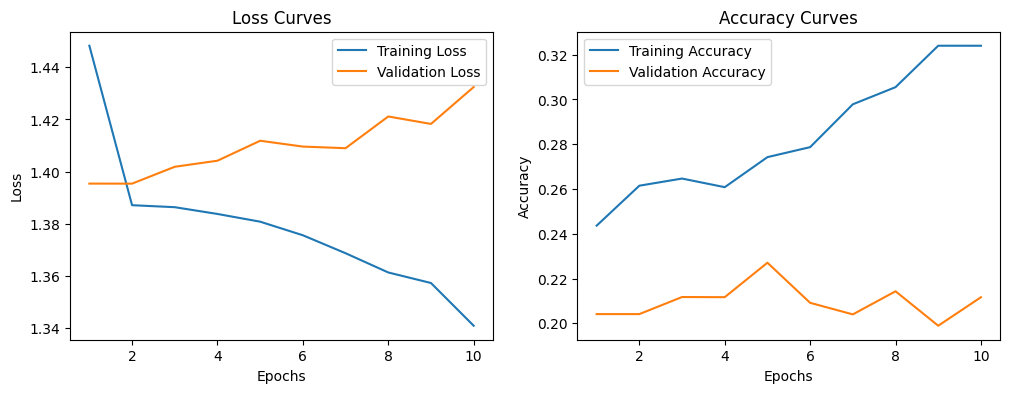

In [ ]:
epochs = range(1, 11)

plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(epochs, avg_epoch_losses, label='Training Loss')
plt.plot(epochs, avg_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(epochs, avg_accuracies, label='Training Accuracy')
plt.plot(epochs, avg_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


In [ ]:
def validate_with_confusion(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy, all_labels, all_preds


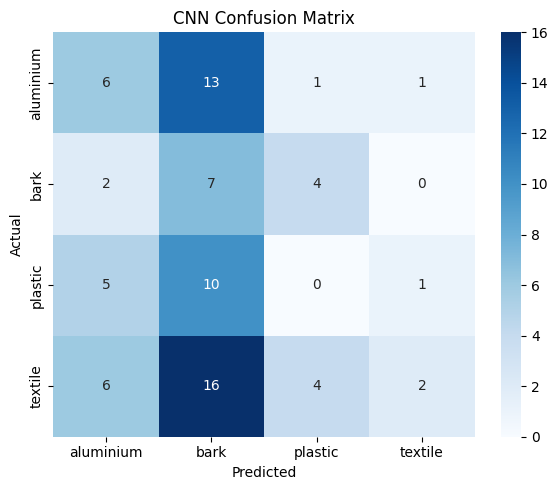

In [ ]:
val_loss, val_acc, y_true, y_pred = validate_with_confusion(model, val_loader, loss_fn, device)

cm = confusion_matrix(y_true, y_pred)
labels = dataset.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title(f'CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


## With Hyperparameter tuning

In [ ]:
def create_model(learning_rate, dropout_rate):
    model = ourCNN(num_classes=4)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

def train_model(model, optimizer, train_loader, val_loader, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_one_epoch(model, train_loader, loss_fn, optimizer, device)

    val_loss, val_acc = validate(model, val_loader, loss_fn, device)
    return val_acc


In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.3, 0.5, 0.7]
}

best_acc = 0
best_params = None

for params in ParameterGrid(param_grid):
    model, optimizer = create_model(params['learning_rate'], params['dropout_rate'])
    val_acc = train_model(model, optimizer, train_loader, val_loader)

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params

print(f'Best Accuracy: {best_acc:.2f}')
print(f'Best Parameters: {best_params}')


Best Accuracy: 0.26
Best Parameters: {'dropout_rate': 0.5, 'learning_rate': 0.001}


# ResNet

In [ ]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss()


train_losses_resnet, val_losses_resnet = [], []
train_accuracies_resnet, val_accuracies_resnet = [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f'\n--- Fold {fold + 1} ---')

    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)

    Resmodel = ResNetModel(num_classes=len(dataset.classes)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(10):  # Change number of epochs if needed
        train_loss, train_acc = train_one_epoch(Resmodel, train_loader, loss_fn, optimizer, device)
        val_loss, val_acc = validate(Resmodel, val_loader, loss_fn, device)

        print(f'Epoch {epoch+1}: Train Acc={train_acc:.2f}, Val Acc={val_acc:.2f}')
        train_losses_resnet.append(train_loss)
        val_losses_resnet.append(val_loss)
        train_accuracies_resnet.append(train_acc)
        val_accuracies_resnet.append(val_acc)



--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.25, Val Acc=0.24
Epoch 2: Train Acc=0.24, Val Acc=0.24
Epoch 3: Train Acc=0.24, Val Acc=0.27
Epoch 4: Train Acc=0.25, Val Acc=0.28
Epoch 5: Train Acc=0.23, Val Acc=0.30
Epoch 6: Train Acc=0.23, Val Acc=0.28
Epoch 7: Train Acc=0.24, Val Acc=0.25
Epoch 8: Train Acc=0.27, Val Acc=0.28
Epoch 9: Train Acc=0.24, Val Acc=0.28
Epoch 10: Train Acc=0.27, Val Acc=0.28

--- Fold 2 ---
Epoch 1: Train Acc=0.19, Val Acc=0.22
Epoch 2: Train Acc=0.24, Val Acc=0.28
Epoch 3: Train Acc=0.22, Val Acc=0.28
Epoch 4: Train Acc=0.22, Val Acc=0.25
Epoch 5: Train Acc=0.21, Val Acc=0.27
Epoch 6: Train Acc=0.21, Val Acc=0.29
Epoch 7: Train Acc=0.22, Val Acc=0.30
Epoch 8: Train Acc=0.28, Val Acc=0.32
Epoch 9: Train Acc=0.26, Val Acc=0.30
Epoch 10: Train Acc=0.23, Val Acc=0.32

--- Fold 3 ---
Epoch 1: Train Acc=0.29, Val Acc=0.27
Epoch 2: Train Acc=0.25, Val Acc=0.24
Epoch 3: Train Acc=0.24, Val Acc=0.27
Epoch 4: Train Acc=0.25, Val Acc=0.29
Epoch 5: Train Acc=0.26, Val Acc=0.32
Epoch 6: Train A

In [ ]:
average_train_accuracy_resnet = sum(train_accuracies_resnet) / len(train_accuracies_resnet)
print(f'Average Training Accuracy: {average_train_accuracy_resnet:.2f}')

average_accuracy_resnet = sum(val_accuracies_resnet) / len(val_accuracies_resnet)
print(f'Average Validation Accuracy: {average_accuracy_resnet:.2f}')


Average Training Accuracy: 0.25
Average Validation Accuracy: 0.26


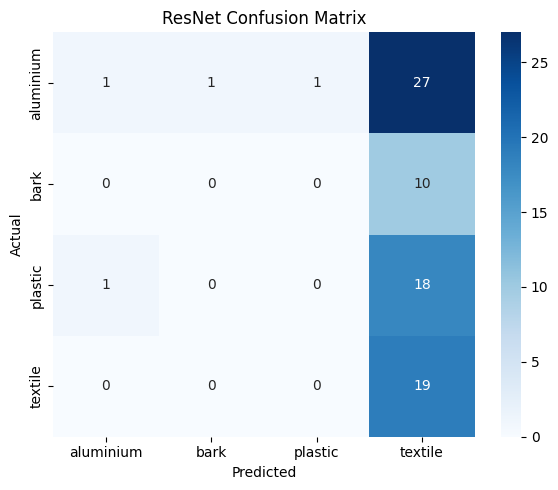

In [ ]:
val_loss, val_acc, y_true, y_pred = validate_with_confusion(Resmodel, val_loader, loss_fn, device)

cm = confusion_matrix(y_true, y_pred)
labels = dataset.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title(f'ResNet Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# SVM

In [ ]:
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
images, labels = next(iter(dataloader))
flattened_images = images.view(images.size(0), -1).numpy()
labels = labels.numpy()

scaler = StandardScaler()
flattened_images = scaler.fit_transform(flattened_images)

In [ ]:
from sklearn.model_selection import GridSearchCV
svm = SVC()


param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=2, return_train_score=True)


grid_search_svm.fit(flattened_images, labels)

print("Best Parameters:", grid_search_svm.best_params_)
print("Best Cross-Validation Score:", grid_search_svm.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.24935185185185188


In [ ]:
results_svm = grid_search_svm.cv_results_

best_index = grid_search_svm.best_index_

val_accuracy_svm = results_svm['mean_test_score'][best_index]
print(f"Validation Accuracy (CV mean of best model): {val_accuracy_svm:.4f}")

train_accuracy_svm = results_svm['mean_train_score'][best_index] if 'mean_train_score' in results else None
if train_accuracy_svm is not None:
    print(f"Training Accuracy (CV mean of best model): {train_accuracy_svm:.4f}")

Validation Accuracy (CV mean of best model): 0.2419
Training accuracy not computed. Enable it by setting `return_train_score=True`.


In [ ]:
best_svm = grid_search_svm.best_estimator_
y_pred = best_svm.predict(flattened_images)
print(classification_report(labels, y_pred, target_names=dataset.classes))

              precision    recall  f1-score   support

   aluminium       0.00      0.00      0.00       100
        bark       0.25      1.00      0.41       102
     plastic       0.00      0.00      0.00        98
     textile       0.00      0.00      0.00       101

    accuracy                           0.25       401
   macro avg       0.06      0.25      0.10       401
weighted avg       0.06      0.25      0.10       401



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=2, return_train_score=True)

grid_search_rf.fit(flattened_images, labels)

print("Best Parameters:", grid_search_rf.best_params_)
print("Best Cross-Validation Score:", grid_search_rf.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Score: 0.20712962962962966


In [ ]:
results_rf = grid_search_rf.cv_results_

best_index = grid_search_rf.best_index_

val_accuracy_rf = results_rf['mean_test_score'][best_index]
print(f"Validation Accuracy (CV mean of best model): {val_accuracy_rf:.4f}")

train_accuracy_rf = results_rf['mean_train_score'][best_index] if 'mean_train_score' in results_rf else None
if train_accuracy_rf is not None:
    print(f"Training Accuracy (CV mean of best model): {train_accuracy_rf:.4f}")

Validation Accuracy (CV mean of best model): 0.2071
Training Accuracy (CV mean of best model): 0.9988


In [ ]:
best_rf = grid_search_rf.best_estimator_
y_pred = best_rf.predict(flattened_images)
print(classification_report(labels, y_pred, target_names=dataset.classes))

              precision    recall  f1-score   support

   aluminium       1.00      1.00      1.00       100
        bark       1.00      1.00      1.00       102
     plastic       1.00      1.00      1.00        98
     textile       1.00      1.00      1.00       101

    accuracy                           1.00       401
   macro avg       1.00      1.00      1.00       401
weighted avg       1.00      1.00      1.00       401

